In [1]:
# for testing classical we will work only with IP photos

'/kaggle/input/smartphone-image-denoising-dataset/SIDD_Small_sRGB_Only/Data/0033_001_IP_00100_00160_3200_N/NOISY_SRGB_010.PNG' # low-light
'/kaggle/input/smartphone-image-denoising-dataset/SIDD_Small_sRGB_Only/Data/0030_001_IP_01600_02000_5500_N/NOISY_SRGB_010.PNG' # bright

'/kaggle/input/smartphone-image-denoising-dataset/SIDD_Small_sRGB_Only/Data/0030_001_IP_01600_02000_5500_N/NOISY_SRGB_010.PNG'

In [ ]:
img_path_noisy = "/kaggle/input/smartphone-image-denoising-dataset/SIDD_Small_sRGB_Only/Data/0033_001_IP_00100_00160_3200_N/NOISY_SRGB_010.PNG"
img_path_clean = "/kaggle/input/smartphone-image-denoising-dataset/SIDD_Small_sRGB_Only/Data/0033_001_IP_00100_00160_3200_N/GT_SRGB_010.PNG"

In [2]:
# !pip install bm3d --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.0/862.0 kB 11.6 MB/s eta 0:00:0000:010:01


In [3]:
# Importing libraries

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.restoration import denoise_tv_chambolle
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import kagglehub
import torch.nn.functional as F
from skimage.restoration import denoise_nl_means
from bm3d import bm3d, BM3DProfile
from tqdm import tqdm
import json

In [4]:
# Step 1: Download Kaggle dataset

import kagglehub
path = kagglehub.dataset_download("rajat95gupta/smartphone-image-denoising-dataset")
print("Path to dataset files:", path)
data_path = os.path.join(path, "SIDD_Small_sRGB_Only", "Data")

Path to dataset files: /kaggle/input/smartphone-image-denoising-dataset


In [5]:
# Step 2: Dataset loader (SIDD structure-aware)

class SIDD_Dataset(Dataset):
    def __init__(self, data_dir, transform=None, size=(256, 256)):
        
        self.pairs = []
        for folder in sorted(os.listdir(data_dir)):
            folder_path = os.path.join(data_dir, folder)
            if not os.path.isdir(folder_path):
                continue
            noisy_path = os.path.join(folder_path, "NOISY_SRGB_010.PNG")
            clean_path = os.path.join(folder_path, "GT_SRGB_010.PNG")
            if os.path.exists(noisy_path) and os.path.exists(clean_path):
                self.pairs.append((noisy_path, clean_path))

        self.size = size
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        noisy_path, clean_path = self.pairs[idx]
        noisy = cv2.imread(noisy_path, cv2.IMREAD_COLOR)
        clean = cv2.imread(clean_path, cv2.IMREAD_COLOR)

        # Convert to RGB and normalize
        noisy = cv2.cvtColor(noisy, cv2.COLOR_BGR2RGB) / 255.0
        clean = cv2.cvtColor(clean, cv2.COLOR_BGR2RGB) / 255.0

        # Resize all images to fixed size
        noisy = cv2.resize(noisy, self.size, interpolation=cv2.INTER_AREA)
        clean = cv2.resize(clean, self.size, interpolation=cv2.INTER_AREA)

        # Convert to torch.float32 tensors
        noisy = torch.tensor(noisy, dtype=torch.float32).permute(2, 0, 1)
        clean = torch.tensor(clean, dtype=torch.float32).permute(2, 0, 1)

        return noisy, clean

# Classical Approach

In [22]:
# Step 3: Classical methods

# TV denoising
def tv_denoise_single(img, weight=0.5):
    img_np = img.permute(1, 2, 0).cpu().numpy()
    tv_img = denoise_tv_chambolle(img_np, weight=weight, channel_axis=-1)
    return torch.tensor(tv_img, dtype=torch.float32).permute(2, 0, 1)

# Neighborhood averaging
def mean_filter_single(img, kernel_size=3):
    pad = kernel_size // 2
    kernel = torch.ones((3, 1, kernel_size, kernel_size), dtype=torch.float32)
    kernel /= (kernel_size * kernel_size)
    img = img.unsqueeze(0)  # (1,3,H,W)
    filtered_channels = []
    for c in range(3):
        chan = img[:, c:c+1]
        conv = F.conv2d(chan, kernel[c:c+1], padding=pad)
        filtered_channels.append(conv)
    out = torch.cat(filtered_channels, dim=1)
    return out.squeeze(0)   # (3,H,W)


# Bilateral filtering
def bilateral_filter_single(img, d=9, sigmaColor=75, sigmaSpace=75):
    img_np = img.permute(1, 2, 0).cpu().numpy()
    filt = cv2.bilateralFilter((img_np * 255).astype(np.uint8), d, sigmaColor, sigmaSpace)
    return torch.tensor(filt / 255.0, dtype=torch.float32).permute(2, 0, 1)

# NLM
def nlm_denoise_single(img, h=0.1, patch_size=5, patch_distance=6):
    img_np = img.permute(1, 2, 0).cpu().numpy()
    nlm_img = denoise_nl_means(
        img_np,
        h=h,
        patch_size=patch_size,
        patch_distance=patch_distance,
        channel_axis=-1,
        fast_mode=True
    )
    return torch.tensor(nlm_img, dtype=torch.float32).permute(2, 0, 1)

# Kernel regression
def kernel_regression_single(img, kernel_size=7, sigma=2.0):
    pad = kernel_size // 2
    ax = np.arange(-pad, pad + 1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    kernel = torch.tensor(kernel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    img = img.unsqueeze(0)  # (1,3,H,W)
    channels = []
    for c in range(3):
        conv = F.conv2d(img[:, c:c+1], kernel, padding=pad)
        channels.append(conv)
    out = torch.cat(channels, dim=1)
    return out.squeeze(0)  # (3,H,W)

# BM3D
def bm3d_single(img, sigma=0.05):
    img_np = img.permute(1, 2, 0).cpu().numpy()
    profile = BM3DProfile()  
    bm3d_img = bm3d(img_np, sigma_psd=sigma, profile=profile)
    return torch.tensor(bm3d_img, dtype=torch.float32).permute(2, 0, 1)

In [23]:
# Application of classical methods

img_path = "/kaggle/input/smartphone-image-denoising-dataset/SIDD_Small_sRGB_Only/Data/0030_001_IP_01600_02000_5500_N/NOISY_SRGB_010.PNG"

np_img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) / 255.0
img_t = torch.tensor(np_img, dtype=torch.float32).permute(2,0,1)

for _ in tqdm(range(1), desc="TV Denoising"):
    tv_img = tv_denoise_single(img_t)

for _ in tqdm(range(1), desc="Mean Filter"):
    mean_img = mean_filter_single(img_t)

for _ in tqdm(range(1), desc="Bilateral Filter"):
    bil_img = bilateral_filter_single(img_t)

for _ in tqdm(range(1), desc="Non-Local Means"):
    nlm_img = nlm_denoise_single(img_t)

for _ in tqdm(range(1), desc="Kernel Regression"):
    kern_img = kernel_regression_single(img_t)

# for _ in tqdm(range(1), desc="BM3D"):
#     bm3d_img = bm3d_single(img_t)

Kernel Regression: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


In [31]:
noisy_np = cv2.cvtColor(cv2.imread(img_path_noisy), cv2.COLOR_BGR2RGB) / 255.0
clean_np = cv2.cvtColor(cv2.imread(img_path_clean), cv2.COLOR_BGR2RGB) / 255.0

noisy_t = torch.tensor(noisy_np, dtype=torch.float32).permute(2,0,1)

# --------------------------------------------------------------
# Run filters
# --------------------------------------------------------------

tv_img   = tv_denoise_single(noisy_t).permute(1,2,0).numpy()
mean_img = mean_filter_single(noisy_t).permute(1,2,0).numpy()
bil_img  = bilateral_filter_single(noisy_t).permute(1,2,0).numpy()
nlm_img  = nlm_denoise_single(noisy_t).permute(1,2,0).numpy()
kern_img = kernel_regression_single(noisy_t).permute(1,2,0).numpy()
# bm3d_img = bm3d_single(noisy_t).permute(1,2,0).numpy()

# --------------------------------------------------------------
# Compute metrics
# --------------------------------------------------------------
def compute_metrics(clean, den):
    return (
        psnr(clean, den, data_range=1.0),
        ssim(clean, den, data_range=1.0, channel_axis=-1)
    )

results = {
    "TV":   compute_metrics(clean_np, tv_img),
    "Mean": compute_metrics(clean_np, mean_img),
    "BF":   compute_metrics(clean_np, bil_img),
    "NLM":  compute_metrics(clean_np, nlm_img),
    "KR":   compute_metrics(clean_np, kern_img),
    # "BM3D": compute_metrics(clean_np, bm3d_img)
}

# --------------------------------------------------------------
# Print results cleanly
# --------------------------------------------------------------
print("\n=== PSNR / SSIM Results ===")
for name, (psnr_val, ssim_val) in results.items():
    print(f"{name:5s}  PSNR: {psnr_val:6.2f}   SSIM: {ssim_val:.4f}")


=== PSNR / SSIM Results ===
TV     PSNR:  36.44   SSIM: 0.9528
Mean   PSNR:  31.16   SSIM: 0.6937
BF     PSNR:  34.87   SSIM: 0.8905
NLM    PSNR:  36.66   SSIM: 0.9479
KR     PSNR:  34.48   SSIM: 0.8653


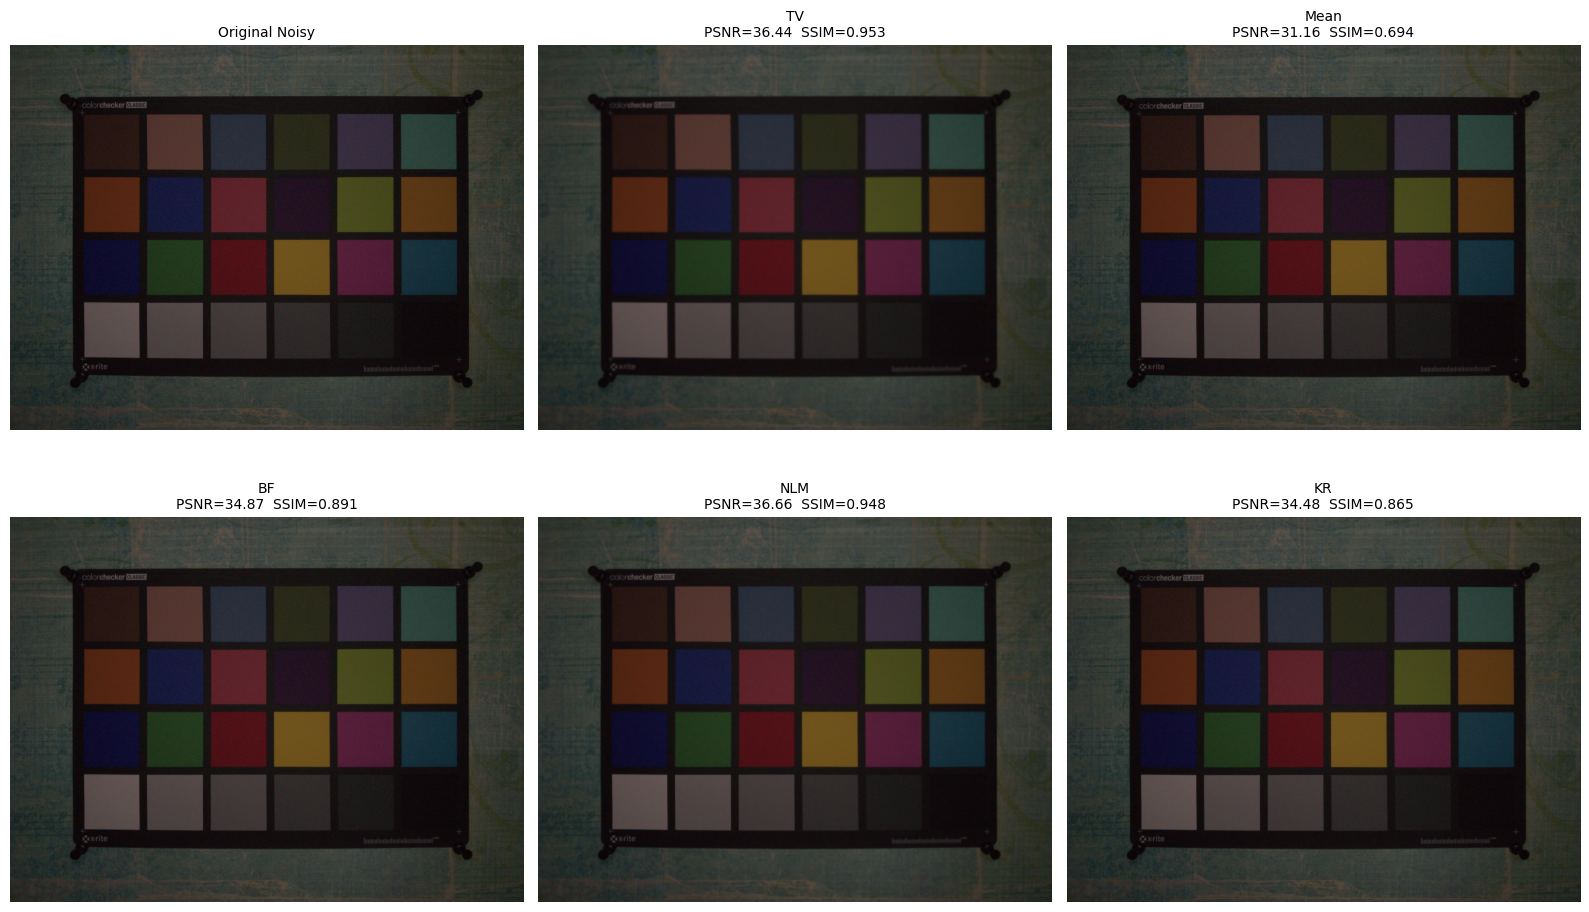

In [32]:
# --------------------------------------------------------------
# Plot results
# --------------------------------------------------------------

titles = {
    "Original Noisy": noisy_np,
    "TV": tv_img,
    "Mean": mean_img,
    "BF": bil_img,
    "NLM": nlm_img,
    "KR": kern_img,
    # "BM3D": bm3d_img
}

# Figure: show denoised images
plt.figure(figsize=(16, 10))
columns = 3
rows = (len(titles) + columns - 1) // columns

i = 1
for name, img in titles.items():
    plt.subplot(rows, columns, i)
    
    # Get metric text
    if name in results:
        ps, ss = results[name]
        plt.title(f"{name}\nPSNR={ps:.2f}  SSIM={ss:.3f}", fontsize=10)
    else:
        plt.title(name, fontsize=10)
    
    plt.imshow(img)
    plt.axis("off")
    i += 1

plt.tight_layout()
plt.show()

In [34]:
# Save images

orig_uint8 = (noisy_np * 255).clip(0,255).astype(np.uint8)
tv_uint8   = (tv_img * 255).clip(0,255).astype(np.uint8)
mean_uint8 = (mean_img * 255).clip(0,255).astype(np.uint8)
bil_uint8  = (bil_img * 255).clip(0,255).astype(np.uint8)
nlm_uint8  = (nlm_img * 255).clip(0,255).astype(np.uint8)
kern_uint8 = (kern_img * 255).clip(0,255).astype(np.uint8)
# bm3d_uint8 = (bm3d_img * 255).clip(0,255).astype(np.uint8)

cv2.imwrite("original.png", cv2.cvtColor(orig_uint8, cv2.COLOR_RGB2BGR))
cv2.imwrite("tv_denoised.png", cv2.cvtColor(tv_uint8, cv2.COLOR_RGB2BGR))
cv2.imwrite("mean_denoised.png", cv2.cvtColor(mean_uint8, cv2.COLOR_RGB2BGR))
cv2.imwrite("bil_denoised.png", cv2.cvtColor(bil_uint8, cv2.COLOR_RGB2BGR))
cv2.imwrite("nlm_denoised.png", cv2.cvtColor(nlm_uint8, cv2.COLOR_RGB2BGR))
cv2.imwrite("kern_denoised.png", cv2.cvtColor(kern_uint8, cv2.COLOR_RGB2BGR))
# cv2.imwrite("bm3d_denoised.png", cv2.cvtColor(bm3d_uint8, cv2.COLOR_RGB2BGR))

True

In [28]:
# Plotting results

def plot_denoising_results(original, tv_img, bil_img, mean_img, nlm_img, kern_img):
    def to_np(img):
        return img.permute(1, 2, 0).cpu().numpy()
    imgs = [
        to_np(original),
        to_np(tv_img),
        to_np(mean_img),
        to_np(bil_img),
        to_np(nlm_img),
        to_np(kern_img)
        # to_np(bm3d_img)
    ]
    titles = [
        "Original Noisy",
         "TV",
        "Mean Filter",
        "Bilateral",
        "Non-Local Means",
        "Kernel Regression"
        # "BM3D"
    ]

    plt.figure(figsize=(16, 12))
    for i, (img, title) in enumerate(zip(imgs, titles)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(title, fontsize=14)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_denoising_results(
    img_t,
    tv_img,
    mean_img,
    bil_img,
    nlm_img,
    kern_img
    # bm3d_img
)

AttributeError: 'numpy.ndarray' object has no attribute 'permute'

In [33]:
# Save images

orig_uint8 = (np_img * 255).clip(0,255).astype(np.uint8)
tv_uint8   = (tv_img.permute(1,2,0).cpu().numpy() * 255).clip(0,255).astype(np.uint8)
mean_uint8   = (mean_img.permute(1,2,0).cpu().numpy() * 255).clip(0,255).astype(np.uint8)
bil_uint8   = (bil_img.permute(1,2,0).cpu().numpy() * 255).clip(0,255).astype(np.uint8)
nlm_uint8   = (nlm_img.permute(1,2,0).cpu().numpy() * 255).clip(0,255).astype(np.uint8)
kern_uint8   = (kern_img.permute(1,2,0).cpu().numpy() * 255).clip(0,255).astype(np.uint8)
# bm3d_uint8   = (bm3d_img.permute(1,2,0).cpu().numpy() * 255).clip(0,255).astype(np.uint8)

cv2.imwrite("original.png", cv2.cvtColor(orig_uint8, cv2.COLOR_RGB2BGR))
cv2.imwrite("tv_denoised.png", cv2.cvtColor(tv_uint8, cv2.COLOR_RGB2BGR))
cv2.imwrite("mean_denoised.png", cv2.cvtColor(mean_uint8, cv2.COLOR_RGB2BGR))
cv2.imwrite("bil_denoised.png", cv2.cvtColor(bil_uint8, cv2.COLOR_RGB2BGR))
cv2.imwrite("nlm_denoised.png", cv2.cvtColor(nlm_uint8, cv2.COLOR_RGB2BGR))
cv2.imwrite("kern_denoised.png", cv2.cvtColor(kern_uint8, cv2.COLOR_RGB2BGR))
# cv2.imwrite("bm3d_denoised.png", cv2.cvtColor(bm3d_uint8, cv2.COLOR_RGB2BGR))

AttributeError: 'numpy.ndarray' object has no attribute 'permute'

# Deep Learning Approach

In [35]:
# Step 4: Deep Learning - Attention U-Net

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, 1),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, 1),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, 1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        if g1.shape[2:] != x1.shape[2:]:
            g1 = nn.functional.interpolate(g1, size=x1.shape[2:], mode='bilinear', align_corners=False)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        # Encoder
        self.enc1 = CBR(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = CBR(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = CBR(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = CBR(256, 512)

        # Decoder
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.att3 = AttentionBlock(256, 256, 128)
        self.dec3 = CBR(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.att2 = AttentionBlock(128, 128, 64)
        self.dec2 = CBR(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)

        self.final = nn.Conv2d(64, 3, 1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))
        x4 = self.bottleneck(self.pool3(x3))

        # Decoder
        d3 = self.up3(x4)
        d3 = nn.functional.interpolate(d3, size=x3.shape[2:], mode='bilinear', align_corners=False)
        x3 = self.att3(d3, x3)
        d3 = torch.cat([d3, x3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = nn.functional.interpolate(d2, size=x2.shape[2:], mode='bilinear', align_corners=False)
        x2 = self.att2(d2, x2)
        d2 = torch.cat([d2, x2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = nn.functional.interpolate(d1, size=x1.shape[2:], mode='bilinear', align_corners=False)
        d1 = torch.cat([d1, x1], dim=1)
        d1 = self.dec1(d1)

        out = self.final(d1)
        return torch.sigmoid(out)

In [36]:
# Step 5: Train and Evaluate

def train_model(model, loader, epochs=10, lr=1e-4, device='cuda'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for noisy, clean in tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}"):
            # Convert to float32 and move to device
            noisy, clean = noisy.to(device).float(), clean.to(device).float()

            optimizer.zero_grad()
            pred = model(noisy)
            loss = criterion(pred, clean)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch+1} | Loss: {total_loss/len(loader):.5f}")


def evaluate(model, loader, device='cuda'):
    model.eval()
    psnr_vals, ssim_vals = [], []

    with torch.no_grad():
        for noisy, clean in loader:
            noisy, clean = noisy.to(device).float(), clean.to(device).float()
            pred = model(noisy).clamp(0, 1)

            # Convert first image in batch to numpy
            pred_np = pred[0].permute(1, 2, 0).cpu().numpy()
            clean_np = clean[0].permute(1, 2, 0).cpu().numpy()

            # Compute metrics (normalize range to 0–1)
            psnr_vals.append(psnr(clean_np, pred_np, data_range=1.0))
            ssim_vals.append(ssim(clean_np, pred_np, data_range=1.0, channel_axis=-1))

    print(f"PSNR: {np.mean(psnr_vals):.2f}, SSIM: {np.mean(ssim_vals):.4f}")

Epoch 1/5: 100%|██████████| 80/80 [03:05<00:00,  2.32s/it]


Epoch 1 | Loss: 0.04212


Epoch 2/5: 100%|██████████| 80/80 [03:05<00:00,  2.32s/it]


Epoch 2 | Loss: 0.02472


Epoch 3/5: 100%|██████████| 80/80 [03:06<00:00,  2.33s/it]


Epoch 3 | Loss: 0.02252


Epoch 4/5: 100%|██████████| 80/80 [03:06<00:00,  2.33s/it]


Epoch 4 | Loss: 0.02054


Epoch 5/5: 100%|██████████| 80/80 [03:06<00:00,  2.33s/it]


Epoch 5 | Loss: 0.01702
PSNR: 21.09, SSIM: 0.7554


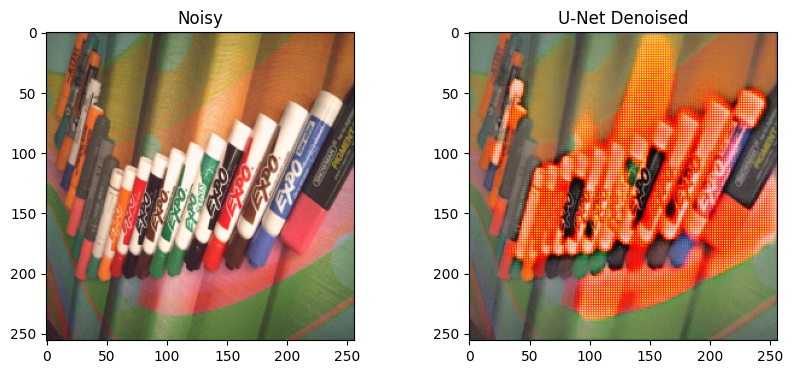

In [43]:
# Step 6: Main Execution

if __name__ == "__main__":
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((256, 256))
    ])
    dataset = SIDD_Dataset(data_path, transform=transform)
    loader = DataLoader(dataset, batch_size=2, shuffle=True)

    noisy_imgs, clean_imgs = next(iter(loader))

    # ---- Deep Learning Denoising ----
    model = UNet()
    train_model(model, loader, epochs=5, lr=1e-4)
    evaluate(model, loader)

    # ---- Visualization ----
    with torch.no_grad():
        pred = model(noisy_imgs.to('cuda')).cpu()
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(noisy_imgs[0].permute(1, 2, 0))
    plt.title("Noisy")
    
    plt.subplot(1, 2, 2)
    plt.imshow(pred[0].permute(1, 2, 0).clamp(0,1))
    plt.title("U-Net Denoised")
    
    plt.show()

In [10]:
# def save_models(unet_model, tv_weight=0.1, folder="models"):
#     os.makedirs(folder, exist_ok=True)

#     # --- Save UNet weights (.pth) ---
#     torch.save(unet_model.state_dict(), os.path.join(folder, "unet_model.pth"))
#     print(f"✅ Saved U-Net weights → {folder}/unet_model.pth")

In [11]:
# def load_models(folder="models"):
#     # --- Load U-Net weights ---
#     model = UNet()
#     model.load_state_dict(torch.load(os.path.join(folder, "unet_model.pth"), map_location="cpu"))
#     model.eval()

#     print(f"✅ Loaded U-Net weights from {folder}/")
#     return model

In [12]:
# if __name__ == "__main__":
#     # Suppose you've already trained your U-Net
#     trained_unet = UNet()  # ← replace with your trained model
#     # e.g., trained_unet.load_state_dict(torch.load("checkpoint.pth"))

#     # Save both models
#     save_models(trained_unet, tv_weight=0.12)

#     # # Load them later
#     loaded_unet = load_models()

✅ Saved U-Net weights → models/unet_model.pth
✅ Loaded U-Net weights from models/


In [44]:
torch.save(model.state_dict(), "models/unet_weights.pth")

In [45]:
loaded_unet = UNet()
state = torch.load("models/unet_weights.pth", map_location='cpu', weights_only=True)
loaded_unet.load_state_dict(state)
loaded_unet.eval()
print("✅ Loaded U-Net weights safely!")

✅ Loaded U-Net weights safely!


In [47]:
import cv2
import torch
import numpy as np
import torch.nn.functional as F

# -----------------------------
# Load image (NO RESIZE)
# -----------------------------
image_path = "/kaggle/input/smartphone-image-denoising-dataset/SIDD_Small_sRGB_Only/Data/0030_001_IP_01600_02000_5500_N/NOISY_SRGB_010.PNG"

img = cv2.imread(image_path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

H, W, _ = img.shape
patch = 256   # model trained on 256x256
overlap = 32  # to avoid seams

device = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# Load trained U-Net
# -----------------------------
model = UNet().to(device)
model.load_state_dict(torch.load("models/unet_weights.pth", map_location=device))
model.eval()

# -----------------------------
# Prepare output canvas
# -----------------------------
output = np.zeros((H, W, 3))
weight = np.zeros((H, W, 1))

# -----------------------------
# Sliding-window tiling
# -----------------------------
with torch.no_grad():
    for y in range(0, H, patch - overlap):
        for x in range(0, W, patch - overlap):

            y_end = min(y + patch, H)
            x_end = min(x + patch, W)

            # extract tile
            tile = img[y:y_end, x:x_end]

            # pad to 256x256 if needed
            tile_padded = np.zeros((patch, patch, 3))
            tile_padded[:(y_end-y), :(x_end-x)] = tile

            # to tensor
            t = torch.tensor(tile_padded, dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)

            # run model
            pred = model(t).cpu().squeeze(0).permute(1,2,0).numpy()
            pred = np.clip(pred, 0, 1)

            # unpad
            pred = pred[:(y_end-y), :(x_end-x)]

            # accumulate
            output[y:y_end, x:x_end] += pred
            weight[y:y_end, x:x_end] += 1

# -----------------------------
# Normalize blended tiles
# -----------------------------
output = output / weight

# -----------------------------
# Save result
# -----------------------------
save_path = "unet_denoised_fullres.png"
cv2.imwrite(save_path, cv2.cvtColor((output * 255).astype("uint8"), cv2.COLOR_RGB2BGR))

print("✅ Saved:", save_path)
print("Original resolution:", H, "×", W)

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# --------------------------------------------------------------
# Load ground truth image (same folder)
# --------------------------------------------------------------
clean_path = image_path.replace("NOISY", "GT")

clean = cv2.imread(clean_path, cv2.IMREAD_COLOR)
clean = cv2.cvtColor(clean, cv2.COLOR_BGR2RGB) / 255.0

# Resize GT? NO — we used full-resolution tiling, so shapes match
assert clean.shape == output.shape, "Error: GT and denoised shapes mismatch!"

# --------------------------------------------------------------
# Compute PSNR and SSIM
# --------------------------------------------------------------
psnr_value = psnr(clean, output, data_range=1.0)
ssim_value = ssim(clean, output, data_range=1.0, channel_axis=-1)

print(f"\nPSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")


✅ Saved: unet_denoised_fullres.png
Original resolution: 3024 × 4032

PSNR: 17.22 dB
SSIM: 0.5589
